In [1]:
WORKING = 0
CRACK = 1
LCD = 2

CLASS_NUMBERS = [WORKING, CRACK, LCD]
CLASS_NAMES = ["Working", "Crack", "LCD"]

NUM_CLASSES = 3

# Creating dummy data

Only run this section if you want to test stuff quickly without dealing with the real dataset.

In [2]:
import numpy as np

rng = np.random.default_rng(0)

X = rng.integers(low = 0, high = 256, size = (100, 400, 300, 3))
y = rng.integers(low = 0, high = NUM_CLASSES, size = 100).reshape((100, 1))

# Reading data from files

Don't run this section if you want to work with dummy data, it will overwrite variables `X` and `y` from previous section.

In [3]:
import os

def collect_file_paths(path: str, ext: str) -> list[str]:
    result = []
    
    for item in os.listdir(path):
        if item != ".ipynb_checkpoints":
            item_path = os.path.join(path, item)
            if os.path.isdir(item_path):
                result.extend(collect_file_paths(item_path, ext))
            elif item_path.endswith(ext):
                result.append(item_path)
                
    return result
        

In [4]:
import cv2
import numpy as np

def images_to_array(image_paths: list[str], shrink_factor: int) -> np.ndarray:
    images = []
    
    for image_file in image_paths:
        image = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        
        new_size = (
            image.shape[1] // shrink_factor, 
            image.shape[0] // shrink_factor
        )
        image = cv2.resize(image, dsize = new_size, interpolation = cv2.INTER_AREA)
        images.append(image)
        
    return np.array(images)

In [5]:
file_paths = collect_file_paths("images_for_model", ".jpeg")

input_filepaths = []
labels_list = []

for path in file_paths:
    file_name = path.split("/")[-1]
    labels = file_name.split("_")
    
    if not ("unknown" in labels):
        if "crack" in labels:
            labels_list.append(CRACK)
        elif "lcd" in labels:
            labels_list.append(LCD)
        else:
            labels_list.append(WORKING)

        input_filepaths.append(path)
        
X = images_to_array(input_filepaths, 20)
y = np.array(labels_list).reshape((len(labels_list), 1))

# Data visualization

In [6]:
NUM_SAMPLES = X.shape[0]
IMAGE_WIDTH = X.shape[1]
IMAGE_HEIGHT = X.shape[2]
IMAGE_SHAPE = (X.shape[1], X.shape[2], X.shape[3])

print("Entire dataset")
print("--------------")
print("Input shape: ", X.shape)
print("Output shape: ", y.shape)
print("Number of working phones: ", np.sum(y == WORKING))
print("Number of cracked phones: ", np.sum(y == CRACK))
print("Number of phones with damaged lcd: ", np.sum(y == LCD))
print("")

Entire dataset
--------------
Input shape:  (259, 201, 151, 3)
Output shape:  (259, 1)
Number of working phones:  132
Number of cracked phones:  111
Number of phones with damaged lcd:  16



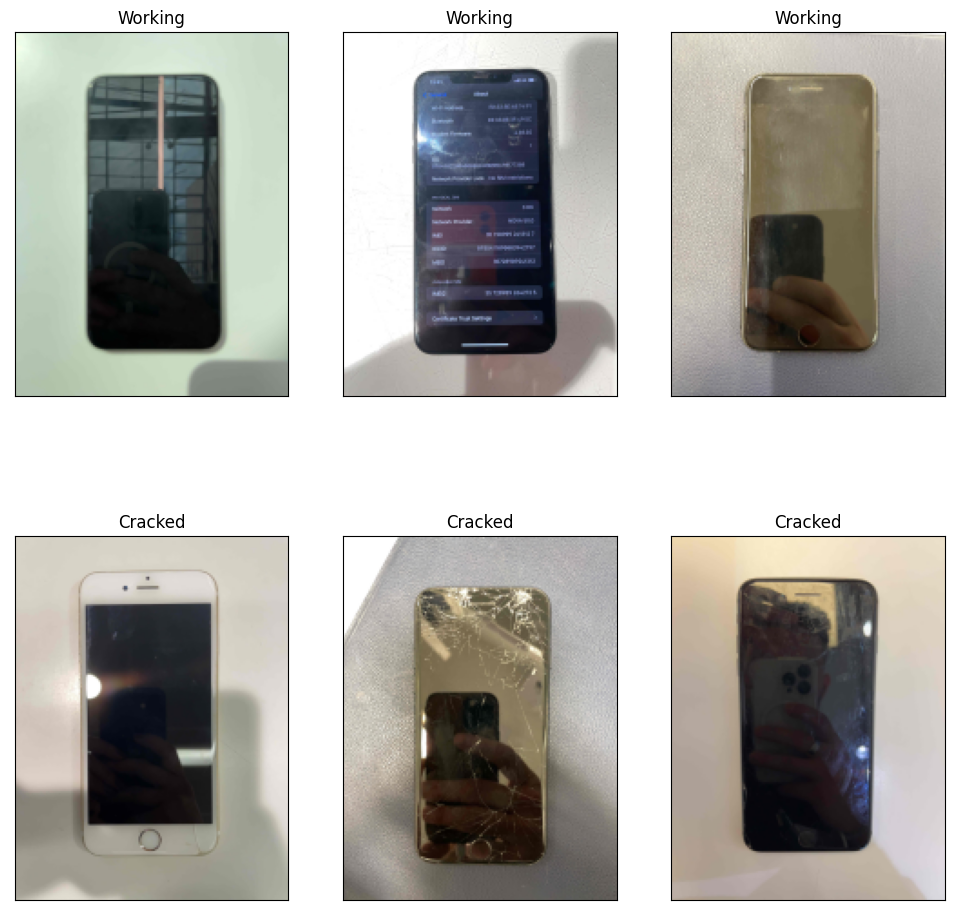

In [7]:
import matplotlib.pyplot as plt

idx_working = np.where(y == WORKING)[0][:3]
idx_cracked = np.where(y == CRACK)[0][:3]

fig, axs = plt.subplots(2, 3, figsize=(12, 12))

for i in range(3):
    axs[0, i].set_title("Working")
    axs[0, i].imshow(X[idx_working[i]])

    axs[1, i].set_title("Cracked")
    axs[1, i].imshow(X[idx_cracked[i]])

plt.setp(axs, xticks=[], yticks=[]) # set all axes off
plt.show()

# Defining the model architecture

In [8]:
from keras import Input, Model, regularizers, optimizers, Sequential
from keras.layers import Conv2D, Activation, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout

# This Convolutional neural network architecture is taken from
# Zeiler et al., Visualizing and Understanding Convolutional Networks (2013)
def define_model(learning_rate = 0.001):
    inputs = Input(shape = IMAGE_SHAPE)
    
    hidden = Conv2D(
        filters = 96, 
        kernel_size = (7, 7), 
        strides = (2, 2),
        activation = "relu"
    )(inputs)
    
    hidden = MaxPooling2D(
        pool_size = (3, 3), 
        strides = (2, 2)
    )(hidden)
    
    # Instance (or Contrast) Normalization
    # https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8
    # https://stackoverflow.com/questions/68088889/how-to-add-instancenormalization-on-tensorflow-keras
    hidden = BatchNormalization(
        axis = 3
    )(hidden, training = True)

    hidden = Conv2D(
        filters = 256, 
        kernel_size = (5, 5), 
        strides = (2, 2),
        activation = "relu"
    )(hidden)

    hidden = MaxPooling2D(
        pool_size = (3, 3), 
        strides = (2, 2)
    )(hidden)
    
    hidden = BatchNormalization(
        axis = 3
    )(hidden, training = True)
  
    hidden = Conv2D(
        filters = 384, 
        kernel_size = (3, 3), 
        strides = (1, 1),
        padding = "same",
        activation = "relu"
    )(hidden)
    
    hidden = Conv2D(
        filters = 384, 
        kernel_size = (3, 3), 
        strides = (1, 1),
        padding = "same",
        activation = "relu"
    )(hidden)
    
    hidden = Conv2D(
        filters = 256, 
        kernel_size = (3, 3), 
        strides = (1, 1),
        padding = "same",
        activation = "relu"
    )(hidden)
    
    hidden = MaxPooling2D(
        pool_size = (3, 3), 
        strides = (2, 2)
    )(hidden)
    
    hidden = BatchNormalization(
        axis = 3
    )(hidden, training = True)
    
    hidden = Flatten()(hidden)
    
    hidden = Dense(4096, activation='relu')(hidden)
    hidden = Dropout(0.5)(hidden)
    hidden = Dense(4096, activation='relu')(hidden)
    hidden = Dropout(0.5)(hidden)
    outputs = Dense(NUM_CLASSES, activation='softmax')(hidden)
    
    model = Model(inputs = inputs, outputs = outputs)

    model.compile(
        loss = 'sparse_categorical_crossentropy', 
        optimizer = optimizers.Adam(learning_rate = learning_rate), 
        metrics = ['accuracy']
    )
    
    return model

2022-12-12 11:03:25.169311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-12 11:03:26.803622: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-12 11:03:40.003398: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/home/kermos/my_env/lib/python3.9/site-packages/cv2/../../lib64:/gpfs/space/

# Training the model using cross-validation and plotting the results

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

K = 5
kFold = StratifiedKFold(n_splits = K, shuffle = True)

confusion_matrices = []
mean_acc = 0
mean_loss = 0

for i, (train_index, test_index) in enumerate(kFold.split(X, y)):
    print("Running Fold", i + 1, "/", K)
    print("----------------")
    model = define_model()
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    history = model.fit(
        x = X_train, y = y_train, 
        validation_data = (X_test, y_test), 
        batch_size = 64, epochs = 7
    )
    
    mean_acc += np.max(history.history['val_accuracy'])
    mean_loss += np.min(history.history['val_loss'])
    
    y_true = y_test.flatten()
    # TODO: model.predict should use weights from the best epoch
    y_pred = np.argmax(model.predict(X_test), axis = 1)
    
    confusion_matrices.append(
        confusion_matrix(y_true, y_pred, labels = CLASS_NUMBERS)
    )

mean_acc /= K
mean_loss /= K

Running Fold 1 / 5
----------------


2022-12-12 11:15:10.472349: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/space/home/kermos/my_env/lib/python3.9/site-packages/cv2/../../lib64:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/perl-5.34.1-4ryb2w6tlh6ha54x25kkpq7l5zjq56do/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/pcre2-10.36-viek2bpe7b5ktcr3qpyl2qhipy2ybjxs/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/curl-7.83.0-yzcvzf3nqftyqhrki2zketnom3lbg3kf/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/zlib-1.2.11-wjg3emtnlrvv3sgzf4bief7g7m64sums/lib:/gpfs/space/software/cluster_software/spack/linux-centos7-x86_64/gcc-9.2.0/openssl-1.1.1o-m6uvz6ittrnhnwd3oftfljxqwkve44j7/lib:/gpfs/space/software/cluster_software/spack/linux

Epoch 1/7
4/4 [==============================] - 16s 4s/step - loss: 10.1079 - accuracy: 0.3961 - val_loss: 7.4647 - val_accuracy: 0.4423
Epoch 2/7
4/4 [==============================] - 15s 3s/step - loss: 5.0473 - accuracy: 0.4879 - val_loss: 5.6502 - val_accuracy: 0.5000
Epoch 3/7
4/4 [==============================] - 14s 4s/step - loss: 2.0016 - accuracy: 0.5942 - val_loss: 2.4093 - val_accuracy: 0.5000
Epoch 4/7
4/4 [==============================] - 17s 4s/step - loss: 1.5329 - accuracy: 0.5121 - val_loss: 1.7560 - val_accuracy: 0.5769
Epoch 5/7
4/4 [==============================] - 15s 3s/step - loss: 0.9644 - accuracy: 0.6039 - val_loss: 1.6288 - val_accuracy: 0.6538
Epoch 6/7
4/4 [==============================] - 15s 4s/step - loss: 0.8419 - accuracy: 0.6184 - val_loss: 1.1784 - val_accuracy: 0.6923
Epoch 7/7
2/2 [==============================] - 1s 463ms/step
Running Fold 2 / 5
----------------
Epoch 1/7
4/4 [==============================] - 16s 4s/step - loss: 6.0966 - 

In [11]:
print("Average accuracy: ", np.round(mean_acc, 3))
print("Average loss: ", np.round(mean_loss, 3))

Average accuracy:  0.626
Average loss:  0.913


Confusion matrix of fold 1 / 5


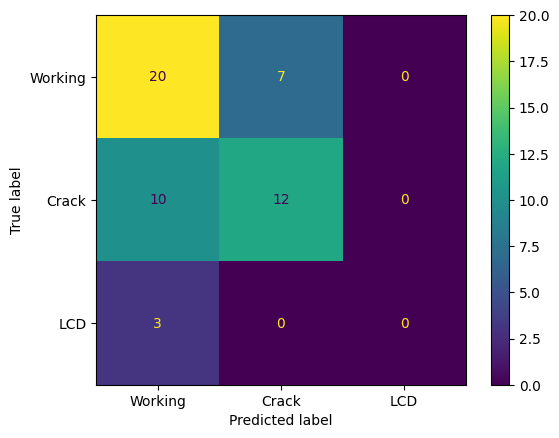

Confusion matrix of fold 2 / 5


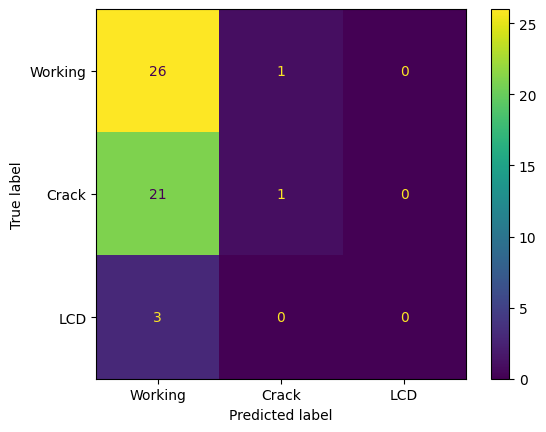

Confusion matrix of fold 3 / 5


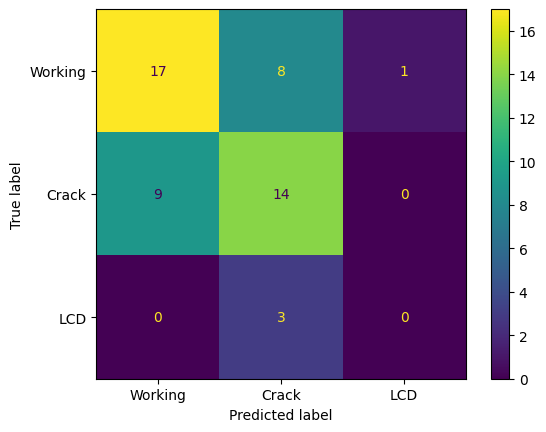

Confusion matrix of fold 4 / 5


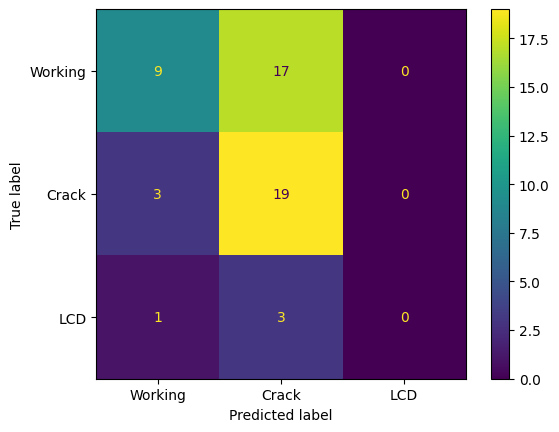

Confusion matrix of fold 5 / 5


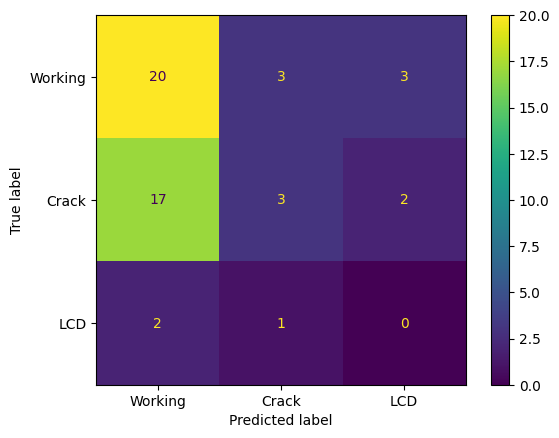

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for i in range(K):
    print("Confusion matrix of fold", i + 1, "/", K)
    
    disp = ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrices[i], 
        display_labels = CLASS_NAMES
    )
    disp.plot()
    plt.show()

# Trained the model on the entire dataset and save it

In [ ]:
model = define_model()

history = model.fit(
    x = X, y = y,
    batch_size = 64, epochs = 10
)
model_folder_name = "cnn_model_acc=" + str(np.round(acc, 3)) + "_loss=" + str(np.round(acc, 3))
model.save("saved_models/" + model_folder_name)